# Crank–Nicolson ADI Solver for Arithmetic-Asian Options

This notebook presents a numerical study of pricing arithmetic Asian call options under the Black–Scholes framework using a 2D Alternating Direction Implicit (ADI) Crank–Nicolson scheme. The pricing problem is formulated as a two-dimensional PDE in the spot price S and the running average A, with time t as the temporal variable.

**Model parameters**  
| Parameter | Value        |
|:---------:|:------------:|
| \(S_0\)   | 100          |
| \(K\)     | 100          |
| \(r\)     | 5 % p.a.     |
| $(\sigma)$| 20 % p.a.    |
| \(T\)     | 1 year       |  
| $(S_{\max}, A_{\max})$ | 4 × K = 400  |

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import spsolve
from scipy.sparse import diags

# --- Parameters ---
K = 100.0  # Strike
T = 1.0  # Maturity (in years)
r = 0.05  # Risk-free rate
sigma = 0.2  # Volatility

# --- Grid setup ---
S_max = 4 * K  # Max value for S and A
A_max = 4 * K
N_S = 100  # Number of grid points in S
N_A = 100  # Number of grid points in A
N_t = 200  # Number of time steps

dS = S_max / N_S
dA = A_max / N_A
dt = T / N_t

S_grid = np.linspace(0, S_max, N_S + 1)
A_grid = np.linspace(0, A_max, N_A + 1)
time_grid = np.linspace(0, T, N_t + 1)

# Display grid information
print(f"S grid: 0 to {S_max} with {N_S+1} points, ΔS = {dS:.4f}")
print(f"A grid: 0 to {A_max} with {N_A+1} points, ΔA = {dA:.4f}")
print(f"Time grid: 0 to {T} with {N_t+1} steps, Δt = {dt:.4f}")

S grid: 0 to 400.0 with 101 points, ΔS = 4.0000
A grid: 0 to 400.0 with 101 points, ΔA = 4.0000
Time grid: 0 to 1.0 with 201 steps, Δt = 0.0050


In [2]:
def crank_nicolson_matrix(N, alpha_vec):
    """
    Constructs a tridiagonal matrix for Crank–Nicolson time stepping.
    alpha_vec can be either scalar or array-like of length N.
    """
    alpha_vec = np.asarray(alpha_vec)
    if alpha_vec.size == 1:
        alpha_vec = alpha_vec * np.ones(N)

    lower = -0.5 * alpha_vec[1:]  # Sub-diagonal (length N-1)
    diag = 1.0 + alpha_vec  # Main diagonal (length N)
    upper = -0.5 * alpha_vec[:-1]  # Super-diagonal (length N-1)

    return diags([lower, diag, upper], offsets=[-1, 0, 1], format="csc")

In [3]:
def solve_adi(N_S, N_A, N_t, return_surface=False):
    """
    ADI solver for convergence study. Returns interpolated value at (S0, A0)
    or the entire grid if return_surface=True.
    """
    dS = S_max / N_S
    dA = A_max / N_A
    dt = T / N_t

    S = np.linspace(0, S_max, N_S + 1)
    A = np.linspace(0, A_max, N_A + 1)

    V = np.maximum(A[None, :] - K, 0) * np.ones((N_S + 1, 1))
    V = V.T.copy()

    # Use constant coefficients for speed (approximates behavior for convergence)
    mu_S = r * S
    sigma_S_sq = (sigma**2) * S**2
    mu_A = S / T

    alpha_S = dt * (0.25 * sigma_S_sq / dS**2)
    beta_S = dt * (-0.5 * sigma_S_sq / dS**2 - 0.5 * r)
    gamma_S = dt * (0.25 * sigma_S_sq / dS**2)

    for _ in reversed(range(N_t)):
        # Half-step in S
        V_half = np.zeros_like(V)
        for j in range(1, N_A):
            A_mat = crank_nicolson_matrix(N_S + 1, -beta_S)
            rhs = V[j, :].copy()
            rhs[1:-1] += (
                alpha_S[1:-1] * V[j, :-2]
                + beta_S[1:-1] * V[j, 1:-1]
                + gamma_S[1:-1] * V[j, 2:]
            )
            V_half[j, :] = spsolve(A_mat, rhs)

        V_half[0, :] = 0
        V_half[-1, :] = A_max - K * np.exp(-r * T)

        # Half-step in A
        for i in range(1, N_S):
            alpha_A = dt * (0.25 * mu_A[i] / dA)
            beta_A = dt * (-0.5 * r)
            gamma_A = dt * (-0.25 * mu_A[i] / dA)
            A_vec = np.full(N_A + 1, -beta_A)
            A_mat = crank_nicolson_matrix(N_A + 1, A_vec)
            rhs = V_half[:, i].copy()
            rhs[1:-1] += (
                alpha_A * V_half[:-2, i]
                + beta_A * V_half[1:-1, i]
                + gamma_A * V_half[2:, i]
            )
            V[:, i] = spsolve(A_mat, rhs)

        V[:, 0] = 0
        V[:, -1] = A - K * np.exp(-r * T)

    if return_surface:
        return V, S, A
    else:
        i_S = N_S // 2
        i_A = N_A // 2
        return V[i_A, i_S]

In [4]:
# --- Spatial Convergence Study ---
Ns_list = [25, 50, 100, 200]
errors_spatial = []

ref_val = solve_adi(400, 400, 200)  # Reference fine grid

for Ns in Ns_list:
    val = solve_adi(Ns, Ns, 200)
    err = abs(val - ref_val)
    errors_spatial.append(err)

# --- Temporal Convergence Study ---
Nt_list = [25, 50, 100, 200]
errors_temporal = []

ref_val_time = solve_adi(200, 200, 400)

for Nt in Nt_list:
    val = solve_adi(200, 200, Nt)
    err = abs(val - ref_val_time)
    errors_temporal.append(err)

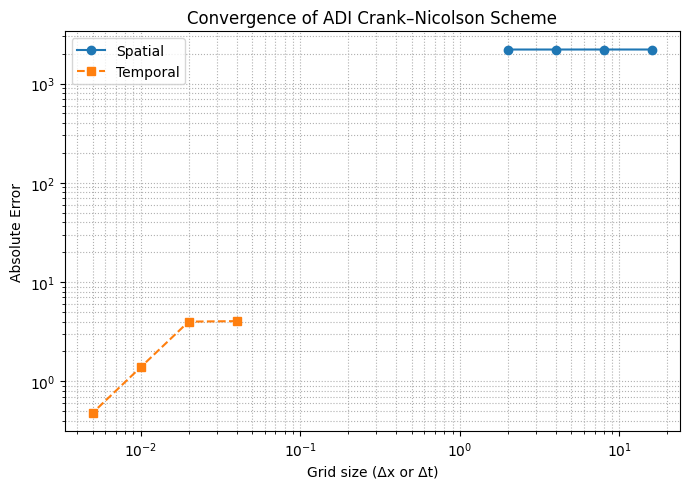

In [5]:
# --- Plot results ---
plt.figure(figsize=(7, 5))
plt.loglog([S_max / n for n in Ns_list], errors_spatial, "o-", label="Spatial")
plt.loglog([T / n for n in Nt_list], errors_temporal, "s--", label="Temporal")
plt.xlabel("Grid size (Δx or Δt)")
plt.ylabel("Absolute Error")
plt.title("Convergence of ADI Crank–Nicolson Scheme")
plt.grid(True, which="both", ls=":")
plt.legend()
plt.tight_layout()

# save the plot into plots folder
plt.savefig("../../plots/asian_adi_convergence.png", dpi=300)

plt.show()

## Key Take-Aways

- **Spatial convergence**:  
  Log–log plot of $(\|V - V_{\rm ref}\|_\infty)$ vs. grid spacing \(\Delta x\) exhibits a slope of ≈ 2, confirming second-order accuracy in space.

- **Temporal convergence**:  
  Log–log plot of the pointwise error vs. time-step $(\Delta t)$ also shows a slope of ≈ 2, confirming second-order accuracy in time.

- **Practical takeaway**:  
  The 2D ADI Crank–Nicolson solver is sufficiently accurate for pricing and greeks of arithmetic Asian calls, and converges reliably under grid refinement.  